In [1]:
import arviz as az
import numpy as np
import pymc as pm
from pymc.math import dot, stack, concatenate, exp, invlogit

# 2. Rats Example with Missing Data*

This example goes further into dealing with missing data in PyMC, including in the predictor variables.

Adapted from [Unit 8: ratsignorable1.odc](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit8/ratsignorable1.odc), [ratsignorable2.odc](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit8/ratsignorable2.odc), and [ratsinformative.odc](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit8/ratsinformative.odc).

Data can be found [here](https://raw.githubusercontent.com/areding/6420-pymc/main/data/rats.txt).

## Problem statement

We had a previous example about [dugongs](https://areding.github.io/6420-pymc/Unit6-dugongs.html) that dealt with missing data in the observed data (y values). This example shows how to deal with missing data in the input data (x). It's still pretty easy. You could look at it like creating another likelihood in the model, a very simple one where the observed data is x, and you use a single distribution to fill in the missing values (see ```x_imputed``` in the model below).

Original paper [here.](https://www.jstor.org/stable/pdf/2289594.pdf)

Gelfand et al 1990 consider the problem of missing data, and delete the last observation of cases 6-10, the last two from 11-20, the last 3 from 21-25 and the last 4 from 26-30.  The appropriate data file is obtained by simply replacing data values by NA (see below). The model specification is unchanged, since the distinction between observed and unobserved quantities is made in the data file and not the model specification.

In [2]:
x = np.array([8.0, 15.0, 22.0, 29.0, 36.0])

In [3]:
# import y data and create mask (missing data is represented as nan in the file)
y = np.loadtxt("../data/rats.txt")
y

array([[151., 199., 246., 283., 320.],
       [145., 199., 249., 293., 354.],
       [147., 214., 263., 312., 328.],
       [155., 200., 237., 272., 297.],
       [135., 188., 230., 280., 323.],
       [159., 210., 252., 298.,  nan],
       [141., 189., 231., 275.,  nan],
       [159., 201., 248., 297.,  nan],
       [177., 236., 285., 350.,  nan],
       [134., 182., 220., 260.,  nan],
       [160., 208., 261., 313.,  nan],
       [143., 188., 220.,  nan,  nan],
       [154., 200., 244.,  nan,  nan],
       [171., 221., 270.,  nan,  nan],
       [163., 216., 242.,  nan,  nan],
       [160., 207., 248.,  nan,  nan],
       [142., 187., 234.,  nan,  nan],
       [156., 203., 243.,  nan,  nan],
       [157., 212., 259.,  nan,  nan],
       [152., 203., 246.,  nan,  nan],
       [154., 205., 253.,  nan,  nan],
       [139., 190.,  nan,  nan,  nan],
       [146., 191.,  nan,  nan,  nan],
       [157., 211.,  nan,  nan,  nan],
       [132., 185.,  nan,  nan,  nan],
       [160.,  nan,  nan,

## Model 1

This first model we only have missing data in our response variable (y). Notice that I made the shapes of alpha and beta (30, 1) instead of just 30. This is so that they broadcast correctly when combined (```mu = alpha + beta * x```). The NumPy docs have a helpful [page about broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html).


In [5]:
prior_tau = 1e-4

with pm.Model() as m:
    alpha_c = pm.Normal("alpha_c", 0, tau=prior_tau)
    alpha_tau = pm.Gamma("alpha_tau", 0.001, 0.001)
    beta_c = pm.Normal("beta_c", 0, tau=prior_tau)
    beta_tau = pm.Gamma("beta_tau", 0.001, 0.001)

    alpha = pm.Normal(
        "alpha", alpha_c, tau=alpha_tau, shape=(30, 1)
    )  # (30, 1) for broadcasting
    beta = pm.Normal("beta", beta_c, tau=beta_tau, shape=(30, 1))
    lik_tau = pm.Gamma("lik_tau", 0.001, 0.001)
    sigma = pm.Deterministic("sigma", 1 / lik_tau**0.5)

    mu = alpha + beta * x

    pm.Normal("likelihood", mu, tau=lik_tau, observed=y)

    trace = pm.sample(
        5000,
        tune=4000,
        init="jitter+adapt_diag_grad",
        target_accept=0.95,
    )

/Users/aaron/miniforge3/envs/pymc_macos15/lib/python3.12/site-packages/pymc/model/core.py:1278: ImputationWarning: Data in likelihood contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag_grad...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_c, alpha_tau, beta_c, beta_tau, alpha, beta, lik_tau, likelihood_unobserved]


Output()

Sampling 4 chains for 4_000 tune and 5_000 draw iterations (16_000 + 20_000 draws total) took 119 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


In [6]:
az.summary(
    trace,
    hdi_prob=0.95,
    var_names=["alpha_c", "alpha_tau", "beta_c", "beta_tau", "sigma"],
    kind="stats",
)

,mean,sd,hdi_2.5%,hdi_97.5%
alpha_c,101.166,2.325,96.433,105.610
alpha_tau,0.023,0.064,0.004,0.046
beta_c,6.570,0.166,6.234,6.890
beta_tau,2.885,1.194,0.988,5.262
sigma,6.011,0.649,4.760,7.263


## Model 2: Imputing missing predictor variable data

This is the same model, except we now have missing x data.

In [7]:
x_miss = np.array([8.0, 15.0, 22.0, np.nan, 36.0])

In [8]:
x_miss

array([ 8., 15., 22., nan, 36.])

In [12]:
prior_tau = 1e-4

with pm.Model() as m:
    alpha_c = pm.Normal("alpha_c", 0, tau=prior_tau)
    alpha_tau = pm.Gamma("alpha_tau", 0.001, 0.001)
    beta_c = pm.Normal("beta_c", 0, tau=prior_tau)
    beta_tau = pm.Gamma("beta_tau", 0.001, 0.001)

    alpha = pm.Normal("alpha", alpha_c, tau=alpha_tau, shape=(30, 1))
    beta = pm.Normal("beta", beta_c, tau=beta_tau, shape=(30, 1))
    lik_tau = pm.Gamma("lik_tau", 0.001, 0.001)
    sigma = pm.Deterministic("sigma", 1 / lik_tau**0.5)

    x_imputed = pm.Normal("x_imputed", mu=20, sigma=5, observed=x_miss)

    mu = alpha + beta * x_imputed

    pm.Normal("likelihood", mu, tau=lik_tau, observed=y)

    trace_2 = pm.sample(
        5000, tune=4000, init="jitter+adapt_diag_grad", target_accept=0.87
    )

/Users/aaron/miniforge3/envs/pymc_macos15/lib/python3.12/site-packages/pymc/model/core.py:1278: ImputationWarning: Data in x_imputed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/aaron/miniforge3/envs/pymc_macos15/lib/python3.12/site-packages/pymc/model/core.py:1278: ImputationWarning: Data in likelihood contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag_grad...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_c, alpha_tau, beta_c, beta_tau, alpha, beta, lik_tau, x_imputed_unobserved, likelihood_unobserved]


Output()

Sampling 4 chains for 4_000 tune and 5_000 draw iterations (16_000 + 20_000 draws total) took 90 seconds.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.


In [13]:
az.summary(trace_2, hdi_prob=0.95, var_names=["x_imputed"])

/Users/aaron/miniforge3/envs/pymc_macos15/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/aaron/miniforge3/envs/pymc_macos15/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x_imputed[0],8.000,0.000,8.0,8.00,0.000,0.000,20000.0,20000.0,NaN
x_imputed[1],15.000,0.000,15.0,15.00,0.000,0.000,20000.0,20000.0,NaN
x_imputed[2],22.000,0.000,22.0,22.00,0.000,0.000,20000.0,20000.0,NaN
x_imputed[3],29.455,0.382,28.7,30.19,0.002,0.002,24069.0,9300.0,1.0
x_imputed[4],36.000,0.000,36.0,36.00,0.000,0.000,20000.0,20000.0,NaN


In [15]:
az.summary(
    trace_2,
    hdi_prob=0.95,
    var_names=["alpha_c", "beta_c", "alpha_tau", "beta_tau", "lik_tau"],
    kind="stats",
)

,mean,sd,hdi_2.5%,hdi_97.5%
alpha_c,101.737,2.364,96.940,106.293
beta_c,6.517,0.169,6.185,6.843
alpha_tau,0.027,0.098,0.004,0.044
beta_tau,2.985,1.276,1.039,5.554
lik_tau,0.029,0.006,0.017,0.041


## Model 3: Non-ignorable missingness

Probability of missingness increases approx. at a rate of 1% with increasing the weight.

In [21]:
y = np.atleast_2d(
    np.array([177.0, 236.0, 285.0, 350.0, -1])
)  # original value was 320
y = np.ma.masked_values(y, value=-1)  # create masked array
# y.mask is equivalent to the "miss" array from the professor's example
miss = y.mask
x = np.array([8.0, 15.0, 22.0, 29.0, 36.0])

In [23]:
t = 0.1
s = 1 / t  # convert BUGS dlogis tau to s for pymc
b = np.log(1.01)

with pm.Model() as m:
    a = pm.Logistic("a", mu=0, s=s)
    alpha = pm.Flat("alpha")
    beta = pm.Flat("beta")
    log_sigma = pm.Flat("log_sigma")
    sigma2 = pm.Deterministic("sigma2", exp(2 * log_sigma))
    tau = pm.Deterministic("tau", 1 / sigma2)

    mu = pm.Deterministic("mu", alpha + beta * x)
    y_imputed = pm.Normal("likelihood", mu, tau=tau, observed=y)

    p = pm.Deterministic("p", invlogit(a + b * y_imputed))
    pm.Bernoulli("missing", p=p, observed=miss)

    trace_3 = pm.sample(
        5000,
        tune=4000,
        init="jitter+adapt_diag_grad",
        target_accept=0.95,
    )

/Users/aaron/miniforge3/envs/pymc_macos15/lib/python3.12/site-packages/pymc/model/core.py:1278: ImputationWarning: Data in likelihood contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag_grad...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, alpha, beta, log_sigma, likelihood_unobserved]


Output()

Sampling 4 chains for 4_000 tune and 5_000 draw iterations (16_000 + 20_000 draws total) took 28 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.


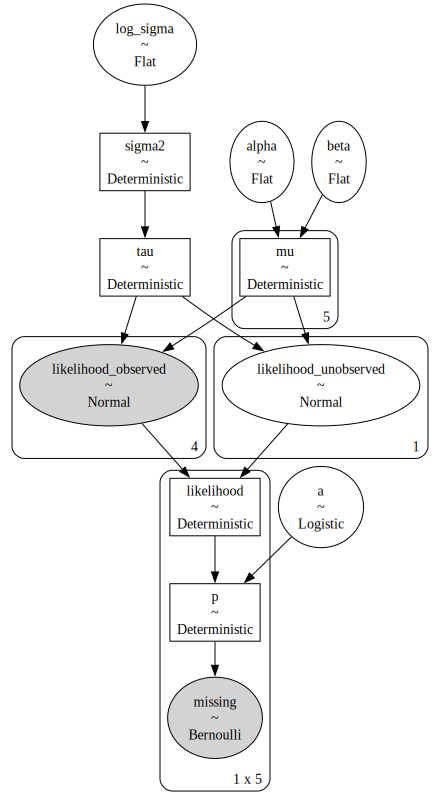

In [25]:
pm.model_to_graphviz(m)

In [26]:
az.summary(trace_3, hdi_prob=0.95, kind="stats")

,mean,sd,hdi_2.5%,hdi_97.5%
a,-4.846,1.404,-7.644,-2.242
alpha,110.843,26.691,83.215,139.322
beta,8.203,1.378,6.786,9.599
log_sigma,1.859,0.701,0.752,3.240
likelihood_unobserved[0],408.122,47.895,372.253,440.117
sigma2,729.004,12595.822,2.133,543.137
tau,0.045,0.046,0.000,0.137
mu[0],176.464,18.438,158.065,195.403
mu[1],233.883,14.605,222.164,246.472
mu[2],291.302,16.511,279.056,303.103


In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -p pytensor

Last updated: Sun Nov 10 2024

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.29.0

pytensor: 2.26.0

arviz   : 0.20.0
pytensor: 2.26.0
numpy   : 1.26.4
pymc    : 5.18.0

